# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Для этого необходимо провести исследовательский анализ данных и установить параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Изучение общей информации в датасете

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'rooms'}>],
       [<AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>,
        <AxesSubplot:title={'center':'floor'}>],
       [<AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>,
        <AxesSubplot:title={'center':'cityCenters_nearest'}>],
       [<AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>,
        <AxesSubplot:title={'center':'ponds_nearest'}>],
       [<AxesSubplot:title={'center':'days_exposition'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], d

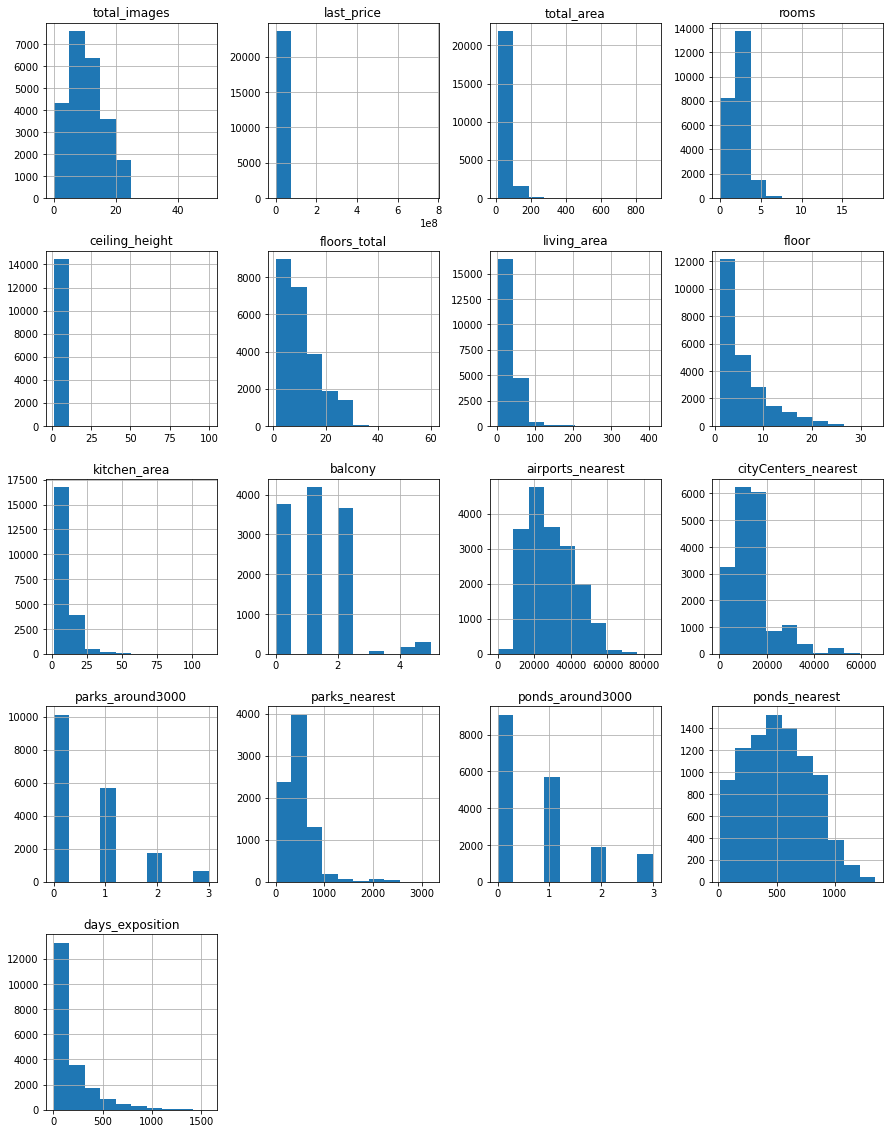

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('/datasets/real_estate_data.csv', sep = '\t')
data.info()
data.head(10)
data.hist(figsize=(15, 20))

#### Вывод
**Таблица состоит из:**
* airports_nearest — расстояние до ближайшего аэропорта в метрах (м)
* balcony — число балконов
* ceiling_height — высота потолков (м)
* cityCenters_nearest — расстояние до центра города (м)
* days_exposition — сколько дней было размещено объявление (от публикации до снятия)
* first_day_exposition — дата публикации
* floor — этаж
* floors_total — всего этажей в доме
* is_apartment — апартаменты (булев тип)
* kitchen_area — площадь кухни в квадратных метрах (м²)
* last_price — цена на момент снятия с публикации
* living_area — жилая площадь в квадратных метрах (м²)
* locality_name — название населённого пункта
* open_plan — свободная планировка (булев тип)
* parks_around3000 — число парков в радиусе 3 км
* parks_nearest — расстояние до ближайшего парка (м)
* ponds_around3000 — число водоёмов в радиусе 3 км
* ponds_nearest — расстояние до ближайшего водоёма (м)
* rooms — число комнат
* studio — квартира-студия (булев тип)
* total_area — общая площадь квартиры в квадратных метрах (м²)
* total_images — число фотографий квартиры в объявлении

**Предварительный анализ показал что:**
* first_day_exposition - должен быть тип datetime
* floors_total - должен быть тип int
* is_apartment - должен быть тип bool
* parks_around3000 - тип должен быть int
* ponds_around3000 - тип должен быть int
* days_exposition - тип должен быть int
* balcony - тип должен быть int
* также везде присутствуют пропуски данных


### Предобработка данных

Можно сделать предположение, что нулевые значения в столбцах *balcony, parks_around3000 и ponds_around3000* означают что балконов в квартире, парков или водоемов неподалеку нет. Следует заменить пропуски на нулевые значения и поменять тип данных.

In [2]:
data['balcony'] = data['balcony'].fillna(0).astype(int)
data['parks_around3000'] = data['parks_around3000'].fillna(0).astype(int)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0).astype(int)

Данные с пустыми значениями в столбцах *floors_total и locality_name* помешают проводить анализ, так что нам нужно избавиться от этих значений.

In [3]:
data.dropna(subset = ['floors_total', 'locality_name'], inplace = True)

Заменим типы данных в столбцах, где это необходимо.

In [4]:
#заполним тут пропуски нулем
data['days_exposition'] = data['days_exposition'].fillna(0).astype(int)

data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%d')
data['is_apartment'] = data['is_apartment'].fillna(False).astype(bool)
data['floors_total'] = data['floors_total'].astype(int)

In [5]:
#проверим наличие явных дупликатов и данные после обработки
data.duplicated().sum()
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23565 non-null  int64         
 1   last_price            23565 non-null  float64       
 2   total_area            23565 non-null  float64       
 3   first_day_exposition  23565 non-null  datetime64[ns]
 4   rooms                 23565 non-null  int64         
 5   ceiling_height        14481 non-null  float64       
 6   floors_total          23565 non-null  int64         
 7   living_area           21700 non-null  float64       
 8   floor                 23565 non-null  int64         
 9   is_apartment          23565 non-null  bool          
 10  studio                23565 non-null  bool          
 11  open_plan             23565 non-null  bool          
 12  kitchen_area          21343 non-null  float64       
 13  balcony         

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.00,8,False,...,25.00,0,Санкт-Петербург,18863.0,16028.0,1,482.0,2,755.0,0
1,7,3350000.0,40.40,2018-12-04,1,NaN,11,18.60,1,False,...,11.00,2,посёлок Шушары,12817.0,18603.0,0,NaN,0,NaN,81
2,10,5196000.0,56.00,2015-08-20,2,NaN,5,34.30,4,False,...,8.30,0,Санкт-Петербург,21741.0,13933.0,1,90.0,2,574.0,558
3,0,64900000.0,159.00,2015-07-24,3,NaN,14,NaN,9,False,...,NaN,0,Санкт-Петербург,28098.0,6800.0,2,84.0,3,234.0,424
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.00,13,False,...,41.00,0,Санкт-Петербург,31856.0,8098.0,2,112.0,1,48.0,121
5,10,2890000.0,30.40,2018-09-10,1,NaN,12,14.40,5,False,...,9.10,0,городской посёлок Янино-1,NaN,NaN,0,NaN,0,NaN,55
6,6,3700000.0,37.30,2017-11-02,1,NaN,26,10.60,6,False,...,14.40,1,посёлок Парголово,52996.0,19143.0,0,NaN,0,NaN,155
7,5,7915000.0,71.60,2019-04-18,2,NaN,24,NaN,22,False,...,18.90,2,Санкт-Петербург,23982.0,11634.0,0,NaN,0,NaN,0
8,20,2900000.0,33.16,2018-05-23,1,NaN,27,15.43,26,False,...,8.81,0,посёлок Мурино,NaN,NaN,0,NaN,0,NaN,189
9,18,5400000.0,61.00,2017-02-26,3,2.50,9,43.60,7,False,...,6.50,2,Санкт-Петербург,50898.0,15008.0,0,NaN,0,NaN,289


array([[<AxesSubplot:title={'center':'total_images'}>,
        <AxesSubplot:title={'center':'last_price'}>,
        <AxesSubplot:title={'center':'total_area'}>,
        <AxesSubplot:title={'center':'first_day_exposition'}>],
       [<AxesSubplot:title={'center':'rooms'}>,
        <AxesSubplot:title={'center':'ceiling_height'}>,
        <AxesSubplot:title={'center':'floors_total'}>,
        <AxesSubplot:title={'center':'living_area'}>],
       [<AxesSubplot:title={'center':'floor'}>,
        <AxesSubplot:title={'center':'kitchen_area'}>,
        <AxesSubplot:title={'center':'balcony'}>,
        <AxesSubplot:title={'center':'airports_nearest'}>],
       [<AxesSubplot:title={'center':'cityCenters_nearest'}>,
        <AxesSubplot:title={'center':'parks_around3000'}>,
        <AxesSubplot:title={'center':'parks_nearest'}>,
        <AxesSubplot:title={'center':'ponds_around3000'}>],
       [<AxesSubplot:title={'center':'ponds_nearest'}>,
        <AxesSubplot:title={'center':'days_exposition'

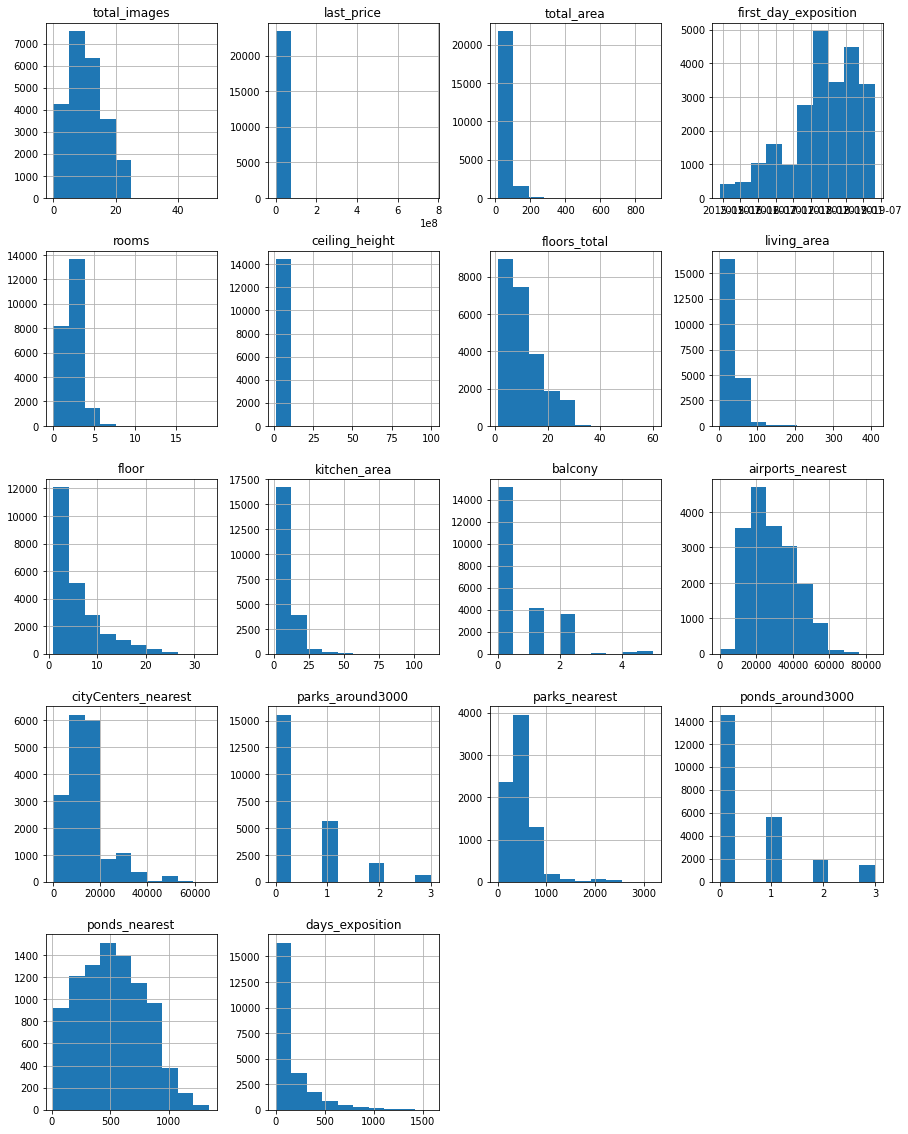

In [6]:
data.hist(figsize=(15, 20))

Не вижу смысла в заполнении пропущенных данных. Врядли заполнение средним или медианным значением будет точным, поэтому будем работать с тем набором данных, который получился.

### Добавление в таблицу новых столбцов

**Нам необходимо добавить:**
* цена одного квадратного метра;
* день публикации объявления (0 - понедельник, 1 - вторник и т. д.);
* месяц и год публикации объявления;
* тип этажа квартиры (значения — «первый», «последний», «другой»);

Расстояние до центра города в километрах не вижу смысла добавлять, так как такой же параметр есть в исходных данных.

In [7]:
#считаем цену одного квадратного метра
data['square_meter_price'] = (data['last_price'] / data['total_area']).astype(int)
#добавляем столбец дня недели публицации
data['day_of_week_exposition'] = data['first_day_exposition'].dt.weekday
#добавляем столбец месяца публикации
data['month_exposition'] = data['first_day_exposition'].dt.month
#добавляем столбец года публикации
data['year_exposition'] = data['first_day_exposition'].dt.year

Добавим столбец подсчета этажа. Напишем функцию, которая определяет этаж и присваивает ему соответствющее значение.

In [8]:
floors_total = data['floors_total']

def floor_category(row):
    floor = row['floor']
    if floor == 1:
        return('первый')
    elif floor == row['floors_total']:
        return('последний')
    return('другой')

#добавляем столбец категории этажа в таблицу
data['floor_category'] = data.apply(floor_category, axis = 1)

Для анализа жилой площади и площади кухни добавим соотношение этих площадей к общей площади.

In [9]:
data['useful_area_factor'] = data['living_area'] / data['total_area']

data['kitchen_area_factor'] = data['kitchen_area'] / data['total_area']
#проверим введение новых столбцов в таблицу
data.info()
data.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23565 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            23565 non-null  int64         
 1   last_price              23565 non-null  float64       
 2   total_area              23565 non-null  float64       
 3   first_day_exposition    23565 non-null  datetime64[ns]
 4   rooms                   23565 non-null  int64         
 5   ceiling_height          14481 non-null  float64       
 6   floors_total            23565 non-null  int64         
 7   living_area             21700 non-null  float64       
 8   floor                   23565 non-null  int64         
 9   is_apartment            23565 non-null  bool          
 10  studio                  23565 non-null  bool          
 11  open_plan               23565 non-null  bool          
 12  kitchen_area            21343 non-null  float6

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,day_of_week_exposition,month_exposition,year_exposition,floor_category,useful_area_factor,kitchen_area_factor
0,20,13000000.0,108.00,2019-03-07,3,2.70,16,51.00,8,False,...,2,755.0,0,120370,3,3,2019,другой,0.472222,0.231481
1,7,3350000.0,40.40,2018-12-04,1,NaN,11,18.60,1,False,...,0,NaN,81,82920,1,12,2018,первый,0.460396,0.272277
2,10,5196000.0,56.00,2015-08-20,2,NaN,5,34.30,4,False,...,2,574.0,558,92785,3,8,2015,другой,0.612500,0.148214
3,0,64900000.0,159.00,2015-07-24,3,NaN,14,NaN,9,False,...,3,234.0,424,408176,4,7,2015,другой,NaN,NaN
4,2,10000000.0,100.00,2018-06-19,2,3.03,14,32.00,13,False,...,1,48.0,121,100000,1,6,2018,другой,0.320000,0.410000
5,10,2890000.0,30.40,2018-09-10,1,NaN,12,14.40,5,False,...,0,NaN,55,95065,0,9,2018,другой,0.473684,0.299342
6,6,3700000.0,37.30,2017-11-02,1,NaN,26,10.60,6,False,...,0,NaN,155,99195,3,11,2017,другой,0.284182,0.386059
7,5,7915000.0,71.60,2019-04-18,2,NaN,24,NaN,22,False,...,0,NaN,0,110544,3,4,2019,другой,NaN,0.263966
8,20,2900000.0,33.16,2018-05-23,1,NaN,27,15.43,26,False,...,0,NaN,189,87454,2,5,2018,другой,0.465320,0.265682
9,18,5400000.0,61.00,2017-02-26,3,2.50,9,43.60,7,False,...,0,NaN,289,88524,6,2,2017,другой,0.714754,0.106557


### Исследовательский анализ данных

#### Анализ данных
  
  **В рамках анализа нам нужно изучить:**
* общая площадь;
* жилая площадь;
* площадь кухни;
* цена объекта;
* количество комнат;
* высота потолков;
* тип этажа квартиры («первый», «последний», «другой»);
* общее количество этажей в доме;
* расстояние до центра города в метрах;
* расстояние до ближайшего парка.

count    23565.000000
mean        60.322824
std         35.657060
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        900.000000
Name: total_area, dtype: float64

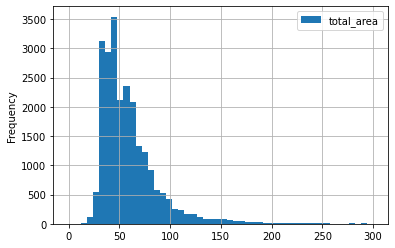

In [10]:
#изучим общую площадь
data.plot(y = 'total_area', kind = 'hist', bins = 50, grid=True, range = (0,300))
data['total_area'].describe()

(11.0, 115.0)

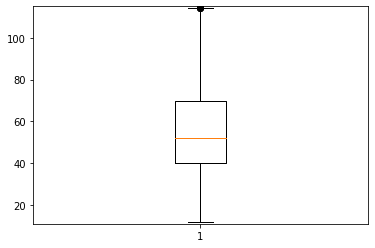

In [11]:
plt.boxplot(data['total_area'])
plt.ylim(11,115)

In [12]:
data[data['total_area'] > 500].sort_values('total_area').tail(20)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,ponds_around3000,ponds_nearest,days_exposition,square_meter_price,day_of_week_exposition,month_exposition,year_exposition,floor_category,useful_area_factor,kitchen_area_factor
8018,20,84000000.0,507.0,2015-12-17,5,4.45,7,301.5,7,True,...,0,NaN,1078,165680,3,12,2015,последний,0.594675,0.089744
4237,1,50000000.0,517.0,2017-10-14,7,NaN,4,332.0,3,False,...,2,540.0,0,96711,5,10,2017,другой,0.642166,0.042553
5358,20,65000000.0,590.0,2019-02-14,15,3.50,6,409.0,3,False,...,0,NaN,14,110169,3,2,2019,другой,0.693220,0.169492
15651,20,300000000.0,618.0,2017-12-18,7,3.40,7,258.0,5,False,...,2,198.0,111,485436,0,12,2017,другой,0.417476,0.113269
3117,19,140000000.0,631.0,2019-03-30,7,NaN,5,NaN,5,False,...,2,210.0,0,221870,5,3,2019,последний,NaN,0.095087
12859,20,140000000.0,631.2,2019-04-09,7,3.90,4,322.3,4,False,...,2,210.0,0,221799,1,4,2019,последний,0.510615,0.030894
19540,8,420000000.0,900.0,2017-12-06,12,2.80,25,409.7,25,False,...,2,318.0,106,466666,2,12,2017,последний,0.455222,0.124444


count    23556.000000
mean        60.116877
std         33.991509
min         12.000000
25%         40.000000
50%         52.000000
75%         69.700000
max        495.000000
Name: total_area, dtype: float64

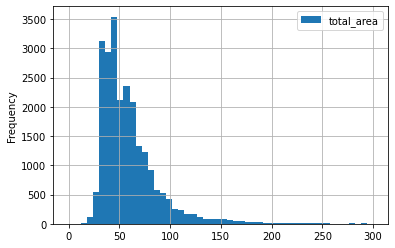

In [13]:
#отбросим явные промышленные помещения
data = data.query('total_area < 500')
data.plot(y = 'total_area', kind = 'hist', bins = 50, grid=True, range = (0,300))
data['total_area'].describe()


Гистограмма по общей площади выглядит нормально. Видим среднюю площадь квартир в 60 кв.м.
Разброс нормальных значений находится в районе от 12 до 114 кв.м.

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23556 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            23556 non-null  int64         
 1   last_price              23556 non-null  float64       
 2   total_area              23556 non-null  float64       
 3   first_day_exposition    23556 non-null  datetime64[ns]
 4   rooms                   23556 non-null  int64         
 5   ceiling_height          14475 non-null  float64       
 6   floors_total            23556 non-null  int64         
 7   living_area             21694 non-null  float64       
 8   floor                   23556 non-null  int64         
 9   is_apartment            23556 non-null  bool          
 10  studio                  23556 non-null  bool          
 11  open_plan               23556 non-null  bool          
 12  kitchen_area            21335 non-null  float6

count    2.355600e+04
mean     6.475525e+06
std      1.015826e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.638000e+06
75%      6.776250e+06
max      7.630000e+08
Name: last_price, dtype: float64

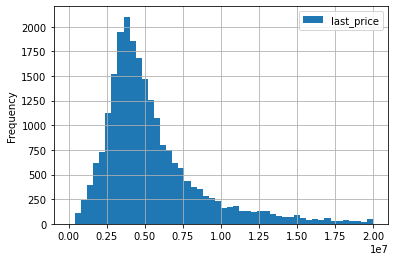

In [15]:
#изучим цену
data.plot(y = 'last_price', kind = 'hist', bins = 50, grid=True, range = (0,20000000))
data['last_price'].describe()

(-100000.0, 12000000.0)

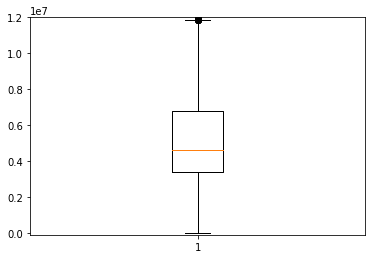

In [16]:
plt.boxplot(data['last_price'])
plt.ylim(-100000,12000000)

count    2.355000e+04
mean     6.380846e+06
std      7.727390e+06
min      1.219000e+04
25%      3.400000e+06
50%      4.631000e+06
75%      6.762544e+06
max      1.908700e+08
Name: last_price, dtype: float64

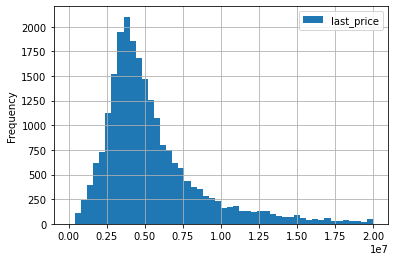

In [17]:
#отбросим квартиры стоимостью более 200 млн.
data = data.query('last_price < 200000000')
data.plot(y = 'last_price', kind = 'hist', bins = 50, grid=True, range = (0,20000000))
data['last_price'].describe()

Гистограмма по цене выглядит нормально. Видим среднюю стоимость квартир в 6,5 млн. Разброс нормальных значений находится в районе от 0 до 11 млн.

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23550 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            23550 non-null  int64         
 1   last_price              23550 non-null  float64       
 2   total_area              23550 non-null  float64       
 3   first_day_exposition    23550 non-null  datetime64[ns]
 4   rooms                   23550 non-null  int64         
 5   ceiling_height          14471 non-null  float64       
 6   floors_total            23550 non-null  int64         
 7   living_area             21688 non-null  float64       
 8   floor                   23550 non-null  int64         
 9   is_apartment            23550 non-null  bool          
 10  studio                  23550 non-null  bool          
 11  open_plan               23550 non-null  bool          
 12  kitchen_area            21330 non-null  float6

count    21688.000000
mean         0.564952
std          0.105311
min          0.021583
25%          0.495444
50%          0.568246
75%          0.637913
max          1.000000
Name: useful_area_factor, dtype: float64

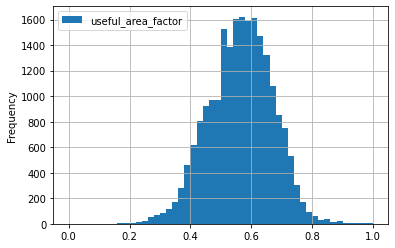

In [19]:
#изучим отношение жилой площади к общей площади
data.plot(y = 'useful_area_factor', kind = 'hist', bins = 50, grid=True, range = (0,1))
data['useful_area_factor'].describe()

count    21330.000000
mean         0.187389
std          0.072963
min          0.025381
25%          0.133333
50%          0.172414
75%          0.232478
max          0.787879
Name: kitchen_area_factor, dtype: float64

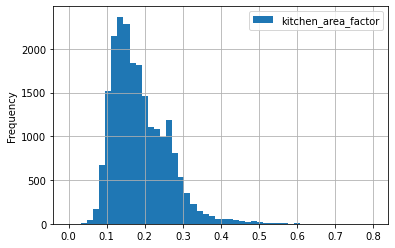

In [20]:
#изучим отношение площади кухни к общей площади
data.plot(y = 'kitchen_area_factor', kind = 'hist', bins = 50, grid=True, range = (0,0.8))
data['kitchen_area_factor'].describe()

Гистограммы по отношению площадей выглядят нормально.

count    23550.000000
mean         2.067771
std          1.069932
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

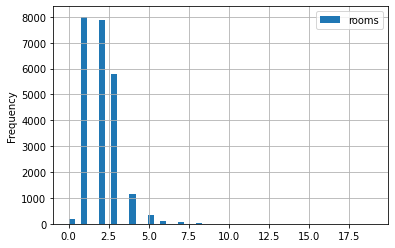

In [21]:
#изучим число комнат
data.plot(y = 'rooms', kind = 'hist', bins = 50, grid=True)
data['rooms'].describe()

(-1.0, 7.0)

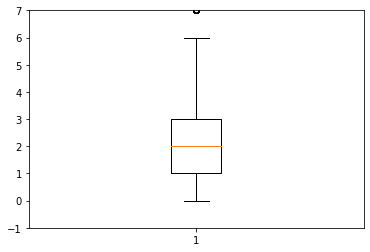

In [22]:
plt.boxplot(data['rooms'])
plt.ylim(-1,7)

count    23546.000000
mean         2.065446
std          1.054718
min          0.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         11.000000
Name: rooms, dtype: float64

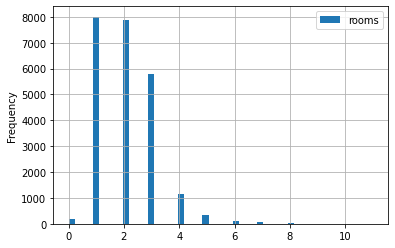

In [23]:
#отбросим количество комнат более 14
data = data.query('rooms < 14')
data.plot(y = 'rooms', kind = 'hist', bins = 50, grid=True)
data['rooms'].describe()

Гистограмма выглядит нормально, у большинства квартир 1-3 комнаты. Видим небольшое количество значений с количеством комнат равных нулю. 
Разброс нормальных значений находится в районе от 0 до 6 квартир.

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23546 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            23546 non-null  int64         
 1   last_price              23546 non-null  float64       
 2   total_area              23546 non-null  float64       
 3   first_day_exposition    23546 non-null  datetime64[ns]
 4   rooms                   23546 non-null  int64         
 5   ceiling_height          14469 non-null  float64       
 6   floors_total            23546 non-null  int64         
 7   living_area             21684 non-null  float64       
 8   floor                   23546 non-null  int64         
 9   is_apartment            23546 non-null  bool          
 10  studio                  23546 non-null  bool          
 11  open_plan               23546 non-null  bool          
 12  kitchen_area            21326 non-null  float6

count    14469.000000
mean         2.770746
std          1.262314
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max        100.000000
Name: ceiling_height, dtype: float64

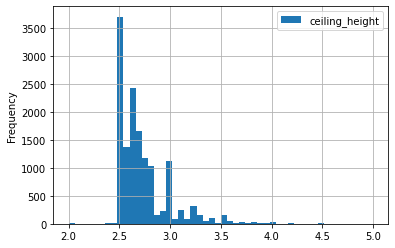

In [25]:
#изучим высоту потолков
data.plot(y = 'ceiling_height', kind = 'hist', bins = 50, range = (2,5), grid=True)
data['ceiling_height'].describe()

count    14468.000000
mean         2.764025
std          0.969560
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max         32.000000
Name: ceiling_height, dtype: float64

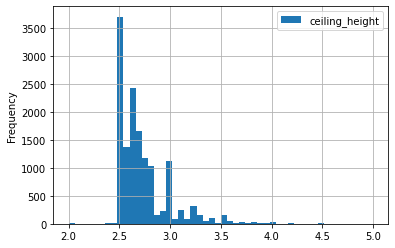

In [26]:
#отбросим высоту потолков больше 14 м., скорее всего это ошибка
data = data.query('ceiling_height < 50 or ceiling_height.isnull()')
data.plot(y = 'ceiling_height', kind = 'hist', bins = 50, range = (2,5), grid=True)
data['ceiling_height'].describe()

Гистограмма выглядит нормально, средняя высота потолков - 2,8 метров, что похоже на действительность.

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23545 entries, 0 to 23698
Data columns (total 29 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   total_images            23545 non-null  int64         
 1   last_price              23545 non-null  float64       
 2   total_area              23545 non-null  float64       
 3   first_day_exposition    23545 non-null  datetime64[ns]
 4   rooms                   23545 non-null  int64         
 5   ceiling_height          14468 non-null  float64       
 6   floors_total            23545 non-null  int64         
 7   living_area             21683 non-null  float64       
 8   floor                   23545 non-null  int64         
 9   is_apartment            23545 non-null  bool          
 10  studio                  23545 non-null  bool          
 11  open_plan               23545 non-null  bool          
 12  kitchen_area            21325 non-null  float6

count    23545.000000
mean        10.678955
std          6.595518
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

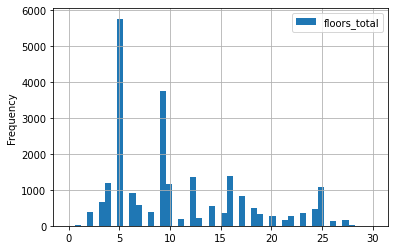

In [28]:
#изучим количество этажей в доме
data.plot(y = 'floors_total', kind = 'hist', bins = 50, range = (0,30), grid=True)
data['floors_total'].describe()

(0.0, 30.0)

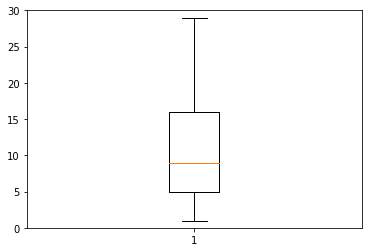

In [29]:
plt.boxplot(data['floors_total'])
plt.ylim(0,30)

Гистограмма выглядит нормально, распределение этажей относительно равномерное, с пиками в самых популярных форматах домов. Разброс нормальных значений находится в районе от 1 до 29 этажей. Отбрасывать этажи не будем, самое высокое здание в Питере имеет 87 этажей, все данные могут быть реальными.

count    18044.000000
mean     14203.235203
std       8611.969743
min        181.000000
25%       9256.250000
50%      13107.000000
75%      16293.000000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

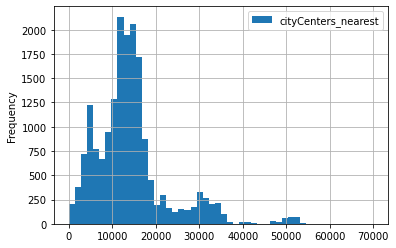

In [30]:
#изучим расстояние до центра
data.plot(y = 'cityCenters_nearest', kind = 'hist', bins = 50, range = (0,70000), grid=True)
data['cityCenters_nearest'].describe()

count    8018.000000
mean      490.663258
std       341.755503
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

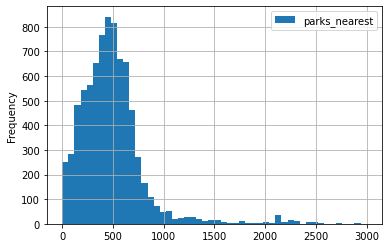

In [31]:
#изучим расстояние до ближайшего парка
data.plot(y = 'parks_nearest', kind = 'hist', bins = 50, range = (0,3000), grid=True)
data['parks_nearest'].describe()

Данные в порядке, аномалий не замечено. Средние расстояния: до центра - 14 км; до ближайшего парка - 500 м.

другой       17318
последний     3318
первый        2909
Name: floor_category, dtype: int64

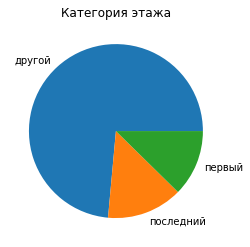

In [32]:
#изучим количество этажей по категориям
data['floor_category'].value_counts().plot(title = 'Категория этажа',kind='pie')
plt.ylabel(None)
data['floor_category'].value_counts()

Данные в порядке, доминируют этажи из категории *другой*. Что каррелирует с анализом по среднему количеству этажей в доме.

#### Исследование скорости продажи квартир

count    23545.000000
mean       156.349968
std        213.344736
min          0.000000
25%         22.000000
50%         73.000000
75%        198.000000
max       1580.000000
Name: days_exposition, dtype: float64

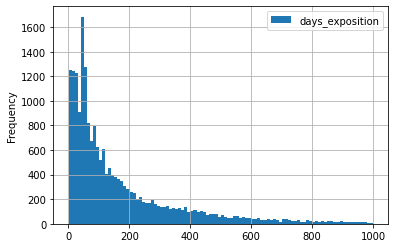

In [33]:
#изучим скорость продажи квартир
data.plot(y='days_exposition',kind = 'hist', grid=True, bins=100,range=(1,1000))
data['days_exposition'].describe()

(0.0, 365.0)

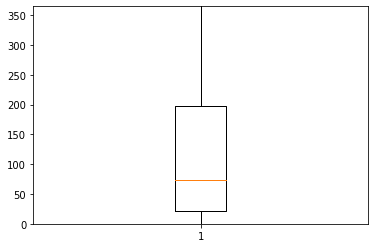

In [34]:
plt.boxplot(data['days_exposition'])
plt.ylim(0,365)

Большое количество значений находится около нуля, исходя из этого напрашивается вывод что:
* либо объявления снимаются с продажи сразу после размещения
* либо в данные закаралась какая-то ошибка

Разброс нормальных значений находится в диапазоне между 20 и 200 днями, что соответствует действительности.

<AxesSubplot:ylabel='Frequency'>

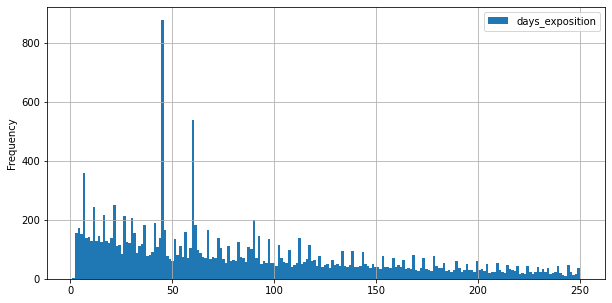

In [35]:
data.plot(y='days_exposition',kind = 'hist', grid=True, bins=200,range=(1,250),figsize=(10,5))

Ситуация стала немного ясней, большая часть квартир продается за полтора-три месяца, что выглядит провдоподобно.
Однако большая часть объявлений снимается сразу же после публикации, что можно списать на первоначальные ошибки в объявлении и его новой загрузки, также имеют место быть дубликаты объявлений или объявления-фальшивки.

In [36]:
#для подсчета среднего и медианного значений отсечем слишком долгие продажи(больше года)
good_sale = data.query('days_exposition < 365')
print('Среднее значение:', good_sale['days_exposition'].mean())
print('Медаинное значение:', good_sale['days_exposition'].median())

Среднее значение: 88.43180377432097
Медаинное значение: 60.0


**Вывод:** В среднем продажа квартиры занимает от полутора до трех месяцев. Быстрые продажи - продажи до одного месяца. Продажи больше года - слишком долгие, вероятно это квартиры, не пользующиеся популярностью, имеющие завышенную стоимость или в плохом состоянии.

#### Определение факторов, которые больше всего влияют на общую (полную) стоимость объекта

Сопоставим данные из столбца с полной ценой с данными об:
* общей площади;
* жилой площади;
* площади кухни;
* количества комнат;
* этажа, на котором расположена квартира (первый, последний, другой);
* даты размещения (день недели, месяц, год).

0.7301186592548411


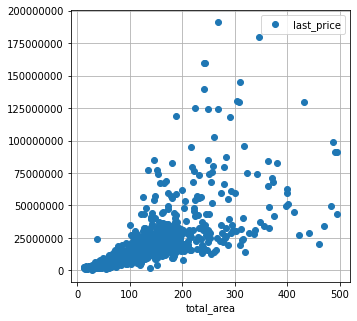

In [37]:
#рассмотрим корреляцию цены от площади
data.pivot_table(index='total_area', values='last_price').plot(grid=True, style='o', figsize=(5, 5))
plt.ticklabel_format(style='plain')
print(data['last_price'].corr(data['total_area']))

Корреляция положительная и сильная. Делаем вывод, что чем больше общая площадь квартиры, тем больше и цена.

0.6531154023527809


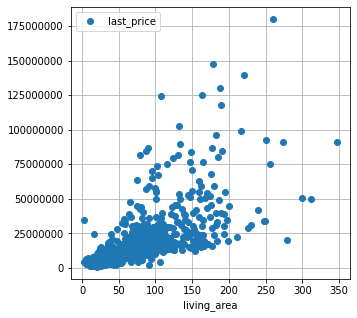

In [38]:
#рассмотрим корреляцию цены от жилой площади
data.pivot_table(index='living_area', values='last_price').plot(grid=True, style='o', figsize=(5, 5))
plt.ticklabel_format(style='plain')
print(data['last_price'].corr(data['living_area']))

Корреляция положительная и также сильная. Делаем вывод, что чем больше жилая площадь квартиры, тем больше и цена.

0.5617489816725676


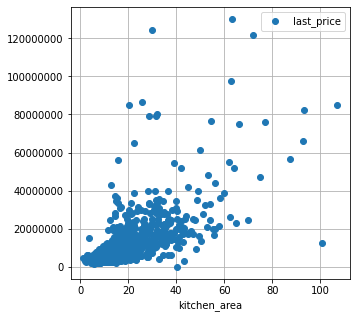

In [39]:
#рассмотрим корреляцию цены от кухонной площади
data.pivot_table(index='kitchen_area', values='last_price').plot(grid=True, style='o', figsize=(5, 5))
plt.ticklabel_format(style='plain')
print(data['last_price'].corr(data['kitchen_area']))

Корреляция положительная, но уже слабее. Но тенденция на увеличение стоимости квартиры от площади кухни срхраняется.

0.43407372198516003


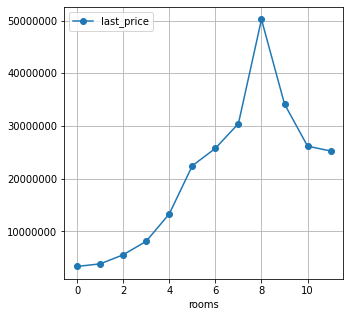

In [40]:
#рассмотрим корреляцию цены от количества комнат
data.pivot_table(index='rooms', values='last_price').plot(grid=True, style='o-', figsize=(5, 5))
plt.ticklabel_format(style='plain')
print(data['last_price'].corr(data['rooms']))

Корреляция небольшая положительная.

Мы видим уменьшение стоимости объекта после 7 квартир. Вполне вероятно что такие большие квартиры являются рабочими помещениями. Ценообразование у таких объектов описывается по другим критериям и мы не можем его проанализировать по текущему набору данных.

0.43407372198516003


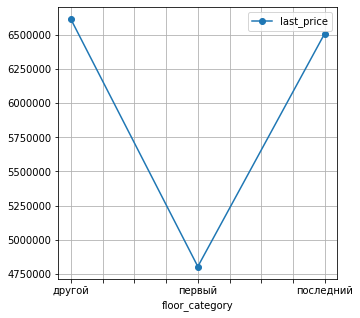

In [41]:
#рассмотрим корреляцию цены от типа этажа
data.pivot_table(index='floor_category', values='last_price').plot(grid=True, style='o-', figsize=(5, 5))
plt.ticklabel_format(axis='y', style='plain')
print(data['last_price'].corr(data['rooms']))

Наблюдаем что цена квартир на первом этаже сильно ниже других. Это связано с неудобством таких квартир.

-0.0019872911192678547


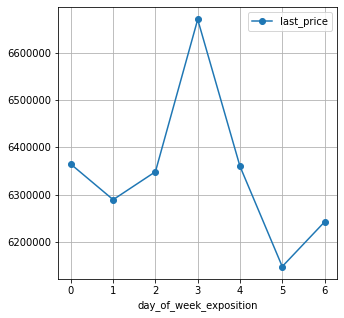

In [42]:
#рассмотрим корреляцию цены от дня публикации
data.pivot_table(index='day_of_week_exposition', values='last_price').plot(grid=True, style='o-', figsize=(5, 5))
plt.ticklabel_format(axis='y', style='plain')
print(data['last_price'].corr(data['day_of_week_exposition']))

-0.0019872911192678547


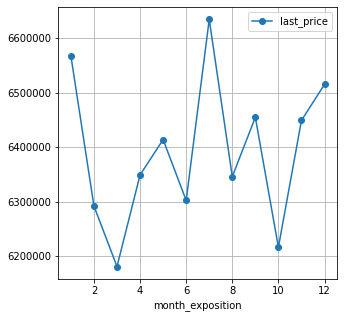

In [43]:
#рассмотрим корреляцию цены от месяца публикации
data.pivot_table(index='month_exposition', values='last_price').plot(grid=True, style='o-', figsize=(5, 5))
plt.ticklabel_format(axis='y', style='plain')
print(data['last_price'].corr(data['day_of_week_exposition']))

-0.0019872911192678547


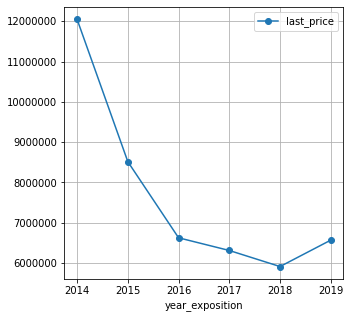

In [44]:
#рассмотрим корреляцию цены от года публикации 
data.pivot_table(index='year_exposition', values='last_price').plot(grid=True, style='o-', figsize=(5, 5))
plt.ticklabel_format(axis='y', style='plain')
print(data['last_price'].corr(data['day_of_week_exposition']))

Корреляция отсутствует, однако наблюдается спад цены после 2014 года по 2018, что, возможно, связано с кризисом. После 2018 года цены пошли вверх, что говорит о росте спроса.

**Вывод:** Наибольшее влияние на стоимост квартиры оказывают, как ожидалось, площадь и этаж квартиры.

#### Подсчет средней цены одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.

Посмотрим и отделим первую десятку НП с объявлениями.

In [45]:
data['locality_name'].value_counts().head(10)

Санкт-Петербург      15631
посёлок Мурино         520
посёлок Шушары         439
Всеволожск             398
Пушкин                 369
Колпино                338
посёлок Парголово      327
Гатчина                307
деревня Кудрово        299
Выборг                 237
Name: locality_name, dtype: int64

In [46]:
top10_data = data.query('locality_name in ["Санкт-Петербург", "посёлок Мурино", "посёлок Шушары", "Всеволожск", "Пушкин", "Колпино", "посёлок Парголово", "Гатчина", "деревня Кудрово", "Выборг"]')
#Создадим свобдную таблицу по первой десятке и цене за кв.м.
top10_data.pivot_table(index='locality_name', values='square_meter_price').sort_values(by='square_meter_price', ascending=False) 


,square_meter_price
locality_name,
Санкт-Петербург,114302.963790
Пушкин,103125.373984
деревня Кудрово,92473.086957
посёлок Парголово,90175.489297
посёлок Мурино,85672.803846
посёлок Шушары,78550.883827
Колпино,75424.150888
Гатчина,68745.693811
Всеволожск,68654.007538


Самая большая стоимость квадратного метра в Санкт-Петербурге, небольшое отставание в Пушкине, далее равномерное снижение стоимости. Замыкает первую десяику Выборг.

#### Вычисление средней стоимости квартир в Санкт-Петербурге на разном удалении от центра

In [47]:
#выделяем квартиры в Санкт-Петербурге
spb_data = data.loc[data['locality_name'] == 'Санкт-Петербург']
#считаем среднюю цену за километр
mean_cost_per_km = spb_data['last_price'].sum()/spb_data['cityCenters_nearest'].sum()
print('Средняя цена для каждого километра составляет', mean_cost_per_km)

Средняя цена для каждого километра составляет 676.95498716974


-0.2695597043155989


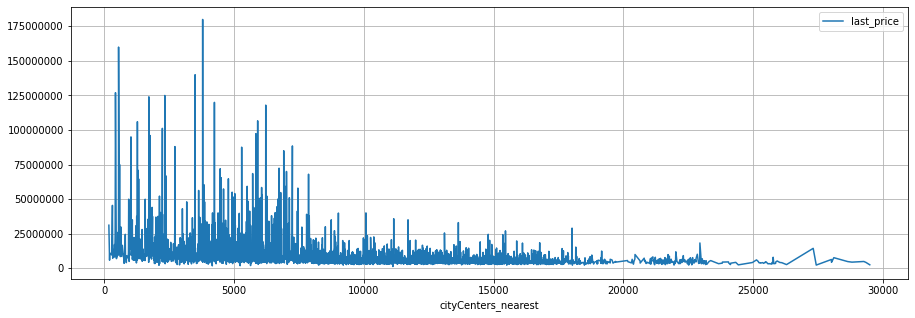

In [48]:
spb_data.pivot_table(index='cityCenters_nearest', values='last_price').plot(figsize=(15,5), grid=True)
plt.ticklabel_format(axis='y', style='plain')
print(data['last_price'].corr(data['cityCenters_nearest']))

С отдалением от центра цена падает, корреляция достаточная.


**Вывод:** Цена, в целом, действительно падает с отдалением от центра, есть небольшие пики, что можно связать либо с завышением цен, либо с продажей квартир в "элитных" районах.

### Общий вывод

Подводя итог проекта, можно сказать что анализ данных полностью произведен.
Мы столкнулись с большим количеством пропусков и аномальных значений, однако успешно их обработали. Также данные были переведены в нужный формат.
Большая часть ошибок в данных, вероятно, связана с человеческими ошибками, однако стоит сделать ремарку что необходимо перепроверить алгоритмы выгрузки данных.

После предобработки в таблицу были добавлены дополнительные параметры, облегчающие анализ.

**Теперь перейдем к результатам анализа:**

* В процессе исследования удалось установить наиболее влияющие на цену квартир факторы - площадь и этаж квартиры являются самыми показательными факторами цены; 
* Также удалось установить что дата продажи особо не влияет на стоимость. Однако можно заметить тенденцию снижения стоимости квартир из-за кризиса с 2014 по 2018 год. После нормализации экономики в 2018 году цены начали расти;
* Стоит отметить что стоимость квартир на первом этаже сильно (порядка 20%) ниже остальных;
* Был составлен топ населенных пунктов по количеству объявлений и цене за квадратный метр, ожидаемо самым дорогим стал Санкт-Петербург (*114334 рублей за метр*) (*по количеству объявлений он также на первом месте*), а самым дешевым - Выборг (*58141*)(*количество объявлений также замыкает первую десятку*);
* Была рассчитана стоимость каждого километра до центра Санкт-Петербурга (*677006 рублей за километр*), однако стоит заметить что также на стоимость квартир влияет район объекта, некоторые квартиры могут стоить дороже даже находясь дальше от центра.


Вся более детальная информация исследования находится внутри проекта, там же представлены все графики и комментарии к ним.